## Writing a general TMM solver
Have to solve a full ass matrix equation, but it's only 4x4, so that should be nice.

After talking with Beicheng... we know only xz and yz anisotropy works. ANY xy anisotropy FAILS, which we believe to be a fundamental issue with the way the equations are formulated here. The issue with xy anisotropy is that we can no longer assume simultaneously that E and H are simple plane waves.

However, one thing should be clear, our eigenvalue sorter still works in this case. More importantly, the case that works is precisely the case that we are trying to solve in our RCWA formalism. 

In [39]:
import sys
sys.path.append('../')
from TMM_functions import PQ_matrices as pq
from TMM_functions import scatter_matrices as sm
from TMM_functions import redheffer_star as rs
from TMM_functions import generate_initial_conditions as ic
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy import linalg as LA
from numpy.linalg import solve as bslash
import time
from convolution_matrices.convmat1D import *
# from RCWA_1D_functions.grating_fft.grating_conv import *

def nonHermitianEigenSorter(eigenvalues):
    N = len(eigenvalues);
    sorted_indices=[];
    sorted_eigs = [];
    for i in range(N):
        eig = eigenvalues[i];
        if(np.real(eig)>0 and np.imag(eig) == 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)==0 and np.imag(eig) > 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)>0 and abs(np.imag(eig)) > 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
    return sorted_eigs, sorted_indices;

# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
'''
'''
L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;

n_ridge = 3.48;              # ridge
n_groove = 3.48;                # groove (unit-less)
lattice_constant = 0.7;  # SI units

## simulation parameters
theta = (45)*np.pi/180;
phi = (45)*np.pi/180;
e_r = 1;
m_r = 1;
e_t = 1;
m_t = 1;
n_i = np.sqrt(e_r);

normal_vector= [0,0,-1]

# epsilon_tensor = np.array([[12,1,0],[0,2,0],[1,0,12]]);
epsilon_tensor = np.array([[1,0,0],[0,1,0],[0,0,1]]);
#epsilon_tensor = np.array([[12,5,0],[5,12,0],[0,0,12]]);
#epsilon_tensor = np.array([[12,1,0],[0,2,0],[1,0,12]]);

#epsilon_tensor = np.array([[12,0,10],[0,12,0],[10,0,12]]);
## if the exy eyx term is equal to exx eyy, then there is a degeneracy which you have to account for.
#epsilon_tensor = np.array([[12,0,0],[0,12,5],[0,5,12]]);

mu_tensor = np.array([[1,0,0],[0,1,0],[0,0,1]])
#epsilon_tensor = 12*np.array([[1,0,0],[0,1,0],[0,0,1]])
I = np.matrix(np.eye(2))

## specify the initial kx and ky
k0=1
kx = k0 *np.sin(theta)*np.cos(phi);
ky = k0 *np.sin(theta)*np.sin(phi);
print(kx, ky)

0.5 0.4999999999999999


In [40]:
## =================  specify gap media ========================##
e_h = 1; m_h = 1;
Pg, Qg, kzg = pq.P_Q_kz(kx, ky, e_h, m_h)
Wg = I;  # Wg should be the eigenmodes of the E field, which paparently is the identity, yes for a homogeneous medium
sqrt_lambda = cmath.sqrt(-1) * Wg;
# remember Vg is really Qg*(Omg)^-1; Vg is the eigenmodes of the H fields
Vg = Qg * Wg * (sqrt_lambda) ** -1;
print(Wg, type(Vg))

[[1. 0.]
 [0. 1.]] <class 'numpy.matrix'>


## Note on PTE and PTM variables
I'm looking into this on the basis that isolated polarizations should not even feel an anisotropic dielectric tensor.
According to CEM EMLab, This specifies the wave polarization with TM being Hy, Ex, Ez and TE being Ey, Hz, Hx

In [41]:
#ampltidue of the te vs tm modes (which are decoupled)
pte = 0; #1/np.sqrt(2);
ptm = 1; #cmath.sqrt(-1)/np.sqrt(2);
polarization_amplitudes = [pte, ptm]
## we can specify this...but note there is no differentation of these after we go through an anisotropic layer

## two options:
We either write it as a second order equation with first order terms or we solve the whole thing.

Solving the whole thing appears to be simpler, but we should note a few things. The biggest thing is that the modes for $W$ are not an identity matrix, which is what we typically assume, even for an isotropic medium.

## debugging
Somehow, even in the TMM formulation, I have an issue with energy conservation as soon as anisotropy is ADDED. Adding anisotropy splits the degeneracy founded in the isotropic version of the problem. This problem occurs only for exy and eyx coupling as well as combined (exz/ezx, eyz/ezy) coupling, something which we will need to figure out.


### TM Polarization Status
Hy, Ex, Ez, only xz anisotropy should be felt, everything else should be consistent.
Only xy fails, which is interesting

### TE Polarization Status
Ey, Hx, Hz Should not see any anisotropy whatsoever.
Only xy fails, which is interesting


### Linear Combo of TE and TM Polarizations
Interesting case, should see the effect of any anisotropy (because you have nonzero components for all E field components)
xz is fine, but yz and xy now fails.

### off normal incidence
Should still be the same as TE and TM analysis. Does not introduce TE/TM coupling


## What's Weird about xy anisotropy 

In [42]:
ref = [];
trans = []
wvlen_scan = np.linspace(0.5, 4, 1000);
thickness = 0.5; # 1 layer
for wvlen in wvlen_scan:
    
    k0 = 2*np.pi/wvlen;
    kx = np.sin(theta)*np.cos(phi);
    ky = np.sin(theta)*np.sin(phi);
    
    # we will build the system by rows?
    a11 = -1j*(ky*mu_tensor[1,2]/mu_tensor[2,2] + kx*(epsilon_tensor[2,0]/epsilon_tensor[2,2]))
    a12 = 1j*kx*(mu_tensor[1,2]/mu_tensor[2,2] - epsilon_tensor[2,1]/epsilon_tensor[2,2]);
#     a13 = kx*ky/epsilon_tensor[2,2] + mu_tensor[1,0] - mu_tensor[1,2]*mu_tensor[2,1]/mu_tensor[2,2];
    a13 = kx*ky/epsilon_tensor[2,2] + mu_tensor[1,0] - mu_tensor[1,2]*mu_tensor[2,0]/mu_tensor[2,2];
#     a14 = -kx**2/epsilon_tensor[2,2] + mu_tensor[1,1]-  mu_tensor[0,2]*mu_tensor[2,1]/mu_tensor[2,2];
    a14 = -kx**2/epsilon_tensor[2,2] + mu_tensor[1,1]-  mu_tensor[1,2]*mu_tensor[2,1]/mu_tensor[2,2];
    
    a21 = 1j* ky *(mu_tensor[0,2]/mu_tensor[2,2] - epsilon_tensor[2,0]/epsilon_tensor[2,2]);
    a22 = -1j * kx*(mu_tensor[0,2]/mu_tensor[2,2]) +ky *(epsilon_tensor[2,1]/epsilon_tensor[2,2]);
    a23 = ky**2/epsilon_tensor[2,2] - mu_tensor[0,0] +  mu_tensor[0,2]*mu_tensor[2,0]/mu_tensor[2,2];
    a24 =  -kx*ky/epsilon_tensor[2,2] - mu_tensor[0,1] + mu_tensor[0,2]*mu_tensor[2,1]/mu_tensor[2,2];
    
#     a31 = (kx*ky/mu_tensor[2,2] + epsilon_tensor[1,0] - epsilon_tensor[1,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2])
    a31 = (kx*ky/mu_tensor[2,2] + epsilon_tensor[1,0] - epsilon_tensor[1,2]*epsilon_tensor[2,0]/epsilon_tensor[2,2])
    a32 = (-kx**2/mu_tensor[2,2] +epsilon_tensor[1,1] - epsilon_tensor[1,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2]);
#     a33 = -1j*(ky*(epsilon_tensor[1,2]/epsilon_tensor[2,2])+kx*(mu_tensor[2,0]/mu_tensor[0,0]));
    a33 = -1j*(ky*(epsilon_tensor[1,2]/epsilon_tensor[2,2])+kx*(mu_tensor[2,0]/mu_tensor[2,2]));
#     a34 = 1j*kx*(epsilon_tensor[1,2]/epsilon_tensor[2,2]+mu_tensor[2,1]/mu_tensor[2,2] )
    a34 = 1j*kx*(epsilon_tensor[1,2]/epsilon_tensor[2,2]-mu_tensor[2,1]/mu_tensor[2,2] )
    
    a41 = ky**2/mu_tensor[2,2] - epsilon_tensor[0,0] +  epsilon_tensor[0,2]*epsilon_tensor[2,0]/epsilon_tensor[2,2];
    a42 = -kx*ky/mu_tensor[2,2] - epsilon_tensor[0,1] + epsilon_tensor[0,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2];
#     a43 = 1j*ky*(epsilon_tensor[0,2]/epsilon_tensor[2,2]+mu_tensor[2,0]/mu_tensor[2,2] );
    a43 = 1j*ky*(epsilon_tensor[0,2]/epsilon_tensor[2,2]-mu_tensor[2,0]/mu_tensor[2,2] );
#     a44 = -1j*(ky*(epsilon_tensor[0,2]/epsilon_tensor[2,2])+kx*(mu_tensor[2,1]/mu_tensor[2,2]));
    a44 = -1j*(kx*(epsilon_tensor[0,2]/epsilon_tensor[2,2])+ky*(mu_tensor[2,1]/mu_tensor[2,2]));
    
    A = np.matrix([[a11, a12, a13, a14],
                  [a21, a22, a23, a24],
                  [a31, a32, a33, a34],
                  [a41, a42, a43, a44]]);
    
    #print(np.linalg.cond(A))
    eigenvals, eigenmodes = np.linalg.eig(A);
    rounded_eigenvals = np.round(eigenvals, 3)
    #print(eigenvals)
    
    #print(np.round(eigenvals,3)); print(np.round(eigenmodes,3))
    
    ## suppose we directly diagonalize this matrix.
    
    
    ## we need to siphon off the forward propagating modes.
    sorted_eigs, sorted_inds = nonHermitianEigenSorter(np.round(eigenvals,10));
#     sorted_inds = [1,3];
#     sorted_eigs = eigenvals[sorted_inds];
    #print(sorted_eigs) ## since we have Ey, Ex, Hy, Hx, on a uniform slab, there is a 2-fold degeneracy 
    
#     plt.plot(np.real(rounded_eigenvals), np.imag(rounded_eigenvals), 'o')
#     plt.plot(np.real(sorted_eigs), np.imag(sorted_eigs), '.r')
#     plt.show()
    
    ## ========================================================
    W_i = eigenmodes[0:2, sorted_inds];
    V_i = eigenmodes[2:, sorted_inds];
    Om =  np.matrix(np.diag(sorted_eigs) );
    #print(np.round(W_i,3), np.round(V_i,3), np.round(Om,3))
    
    #then what... match boundary conditions... try using the gaylord formulation.
    # or use the scattering matrix formalism, where we still, technically deal with all field components...
    
    Sg11 = np.matrix(np.zeros((2, 2))); Sg12 = np.matrix(np.eye(2, 2));
    Sg21 = np.matrix(np.eye(2, 2)); Sg22 = np.matrix(np.zeros((2, 2)));  # matrices
    Sg = np.block([[Sg11, Sg12], [Sg21, Sg22]]);  # initialization is equivelant as that for S_reflection side matrix

    ### ================= Working on the Reflection Side =========== ##
    Pr, Qr, kzr = pq.P_Q_kz(kx, ky, e_r, m_r)

    ## ============== values to keep track of =======================##
    S_matrices = list();
    kz_storage = [kzr];
    X_storage = list();
    ## ==============================================================##

    # define vacuum wavevector k0
    lam0 = wvlen;  # k0 and lam0 are related by 2*pi/lam0 = k0
    k0 = 2*np.pi/lam0;
    ## modes of the layer
    Om_r = np.matrix(cmath.sqrt(-1) * kzr * I);
    X_storage.append(Om_r);
    W_ref = I;
    V_ref = Qr * Om_r.I;  # can't play games with V like with W because matrices for V are complex
    #print(Om_r)
    ## calculating A and B matrices for scattering matrix
    Ar, Br = sm.A_B_matrices(Wg, W_ref, Vg, V_ref);

    S_ref, Sr_dict = sm.S_R(Ar, Br);  # scatter matrix for the reflection region
    S_matrices.append(S_ref);
    Sg, D_r, F_r = rs.RedhefferStar(Sg, S_ref);

    # longitudinal k_vector
    ## ============ WORKING INSIDE ANISOTROPIC LAYER ================#
    # now defIne A and B
    Al, Bl = sm.A_B_matrices(Wg, W_i, Vg, V_i);

    # calculate scattering matrix
    S_layer, Sl_dict = sm.S_layer(Al, Bl, thickness, k0, Om)
    S_matrices.append(S_layer);

    ## update global scattering matrix using redheffer star
    Sg, D_i, F_i = rs.RedhefferStar(Sg, S_layer);

    ##========= Working on the Transmission Side==============##
    Pt, Qt, kz_trans = pq.P_Q_kz(kx, ky, e_t, m_t);
    kz_storage.append(kz_trans);

    Omt = cmath.sqrt(-1) * kz_trans * I;
    Vt = Qt * np.linalg.inv(Omt);

    # get At, Bt
    At, Bt = sm.A_B_matrices(Wg, I, Vg, Vt)

    ST, ST_dict = sm.S_T(At, Bt)
    S_matrices.append(ST);
    # update global scattering matrix
    Sg, D_t, F_t = rs.RedhefferStar(Sg, ST);

    K_inc_vector = n_i * k0 * np.matrix([np.sin(theta) * np.cos(phi), \
                                         np.sin(theta) * np.sin(phi), np.cos(theta)]);

    # cinc is the c1+
    E_inc, cinc, Polarization = ic.initial_conditions(K_inc_vector, theta, normal_vector, pte, ptm)

    ## COMPUTE FIELDS
    Er = Sg[0:2, 0:2] * cinc;  # S11; #(cinc = initial mode amplitudes), cout = Sg*cinc; #2d because Ex, Ey...
    Et = Sg[2:, 0:2] * cinc;  # S21

    Er = np.squeeze(np.asarray(Er));
    Et = np.squeeze(np.asarray(Et));

    Erx = Er[0];  Ery = Er[1]; Etx = Et[0]; Ety = Et[1];

    # apply the grad(E) = 0 equation to get z components, this equation comes out of the longitudinal equation 
    # or the divergence equation and is valid since the transmission region is VACUUM (as is the reflection region)
    Erz = -(kx * Erx + ky * Ery) / kzr; #uses the divergence law
    Etz = -(kx * Etx + ky * Ety) / kz_trans;  ## using divergence of E equation here

    # add in the Erz component to vectors
    Er = np.matrix([Erx, Ery, Erz]);  # a vector
    Et = np.matrix([Etx, Ety, Etz]);

    R = np.linalg.norm(Er) ** 2;
    T = np.linalg.norm(Et) ** 2;
    ref.append(R);
    trans.append(T);

In [43]:
print(A)
print(A.shape)
print(E_inc), #one x and one z
# print(Wg)
# print(Vg)
# print(Om_r)
# # print(ref)
# # print(trans)
# # print(np.round(eigenmodes,3))
# # print(sorted_inds)
# # print(Vg)
# print(eigenvals)
# print(np.round(eigenmodes))

[[ 0.  -0.j  0.  +0.j  0.25+0.j  0.75+0.j]
 [ 0.  +0.j  0.  +0.j -0.75+0.j -0.25+0.j]
 [ 0.25+0.j  0.75+0.j  0.  -0.j  0.  +0.j]
 [-0.75+0.j -0.25+0.j  0.  +0.j  0.  -0.j]]
(4, 4)
[[ 0.5         0.5        -0.70710678]]


(None,)

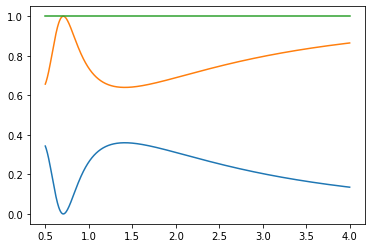

In [44]:
ref = np.array(ref);
trans = np.array(trans)
plt.plot(wvlen_scan, ref);
plt.plot(wvlen_scan, trans);
plt.plot(wvlen_scan, ref+trans)
plt.show()


## figuring out xy to diagonal anisotropy
So what if we diagonalize the xy part?

No, that shouldn't be necessary. As Beicheng mentioned, x-y anisotropy should still result in a block sparse matrix!

In [32]:
epsilon_tensor = np.array([[12,5,0],[5,12,0],[0,10,12]]);

## ================================================
#diagonalize
eps_diag, eps_eigens= np.linalg.eig(epsilon_tensor)
print(eps_diag.shape)
print(eps_eigens.shape) #we need to project all E fields onto this basis, specifically the Ex and Ey fields...
##============

eps_diag = np.diag(eps_diag)
print(eps_diag)
#here's the thing, what do we do with the rest?
# we have to reformulate the problem because every E component gets effectively rescaled...fuck
print(epsilon_tensor)
epsilon_tensor = eps_diag;
print(eps_eigens)

(3,)
(3, 3)
[[12.  0.  0.]
 [ 0. 17.  0.]
 [ 0.  0.  7.]]
[[12  5  0]
 [ 5 12  0]
 [ 0 10 12]]
[[ 0.          0.40824829  0.40824829]
 [ 0.          0.40824829 -0.40824829]
 [ 1.          0.81649658  0.81649658]]


In [8]:
#=====================================


ref = [];
trans = []
wvlen_scan = np.linspace(0.5, 4, 1000);
thickness = 0.5; # 1 layer
for wvlen in wvlen_scan:
    k0 = 2*np.pi/wvlen;
    kx = np.sin(theta)*np.cos(phi);
    ky = np.sin(theta)*np.sin(phi);
    
    # we will build the system by rows?
    a11 = -1j*(ky*mu_tensor[1,2]/mu_tensor[2,2] + kx*(epsilon_tensor[2,0]/epsilon_tensor[2,2]))
    a12 = 1j*kx*(mu_tensor[1,2]/mu_tensor[2,2] - epsilon_tensor[2,1]/epsilon_tensor[2,2]);
#     a13 = kx*ky/epsilon_tensor[2,2] + mu_tensor[1,0] - mu_tensor[1,2]*mu_tensor[2,1]/mu_tensor[2,2];
    a13 = kx*ky/epsilon_tensor[2,2] + mu_tensor[1,0] - mu_tensor[1,2]*mu_tensor[2,0]/mu_tensor[2,2];
#     a14 = -kx**2/epsilon_tensor[2,2] + mu_tensor[1,1]-  mu_tensor[0,2]*mu_tensor[2,1]/mu_tensor[2,2];
    a14 = -kx**2/epsilon_tensor[2,2] + mu_tensor[1,1]-  mu_tensor[1,2]*mu_tensor[2,1]/mu_tensor[2,2];
    
    a21 = 1j* ky *(mu_tensor[0,2]/mu_tensor[2,2] - epsilon_tensor[2,0]/epsilon_tensor[2,2]);
    a22 = -1j * kx*(mu_tensor[0,2]/mu_tensor[2,2]) +ky *(epsilon_tensor[2,1]/epsilon_tensor[2,2]);
    a23 = ky**2/epsilon_tensor[2,2] - mu_tensor[0,0] +  mu_tensor[0,2]*mu_tensor[2,0]/mu_tensor[2,2];
    a24 =  -kx*ky/epsilon_tensor[2,2] - mu_tensor[0,1] + mu_tensor[0,2]*mu_tensor[2,1]/mu_tensor[2,2];
    
#     a31 = (kx*ky/mu_tensor[2,2] + epsilon_tensor[1,0] - epsilon_tensor[1,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2])
    a31 = (kx*ky/mu_tensor[2,2] + epsilon_tensor[1,0] - epsilon_tensor[1,2]*epsilon_tensor[2,0]/epsilon_tensor[2,2])
    a32 = (-kx**2/mu_tensor[2,2] +epsilon_tensor[1,1] - epsilon_tensor[1,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2]);
#     a33 = -1j*(ky*(epsilon_tensor[1,2]/epsilon_tensor[2,2])+kx*(mu_tensor[2,0]/mu_tensor[0,0]));
    a33 = -1j*(ky*(epsilon_tensor[1,2]/epsilon_tensor[2,2])+kx*(mu_tensor[2,0]/mu_tensor[2,2]));
#     a34 = 1j*kx*(epsilon_tensor[1,2]/epsilon_tensor[2,2]+mu_tensor[2,1]/mu_tensor[2,2] )
    a34 = 1j*kx*(epsilon_tensor[1,2]/epsilon_tensor[2,2]-mu_tensor[2,1]/mu_tensor[2,2] )
    
    a41 = ky**2/mu_tensor[2,2] - epsilon_tensor[0,0] +  epsilon_tensor[0,2]*epsilon_tensor[2,0]/epsilon_tensor[2,2];
    a42 = -kx*ky/mu_tensor[2,2] - epsilon_tensor[0,1] + epsilon_tensor[0,2]*epsilon_tensor[2,1]/epsilon_tensor[2,2];
#     a43 = 1j*ky*(epsilon_tensor[0,2]/epsilon_tensor[2,2]+mu_tensor[2,0]/mu_tensor[2,2] );
    a43 = 1j*ky*(epsilon_tensor[0,2]/epsilon_tensor[2,2]-mu_tensor[2,0]/mu_tensor[2,2] );
#     a44 = -1j*(ky*(epsilon_tensor[0,2]/epsilon_tensor[2,2])+kx*(mu_tensor[2,1]/mu_tensor[2,2]));
    a44 = -1j*(kx*(epsilon_tensor[0,2]/epsilon_tensor[2,2])+ky*(mu_tensor[2,1]/mu_tensor[2,2]));
    
    A0 = np.matrix([[a11, a12, a13, a14],
                  [a21, a22, a23, a24],
                  [a31, a32, a33, a34],
                  [a41, a42, a43, a44]]);
    
#     this is wrong...there are three eigenvectors from the rescaling...
#     rescaled1 = eps_eigens[0:2, 0:2]*A0[0:2, 0:2];
#     rescaled2 = eps_eigens[0:2, 0:2]*A0[2:, 0:2];
    
#     #print(rescaled2.shape)
#     A0[0:2, 0:2] = rescaled1;
#     A0[2:, 0:2] = rescaled2;
#     print(A0.shape)
#     print(A0)
    #print(np.linalg.cond(A))
    eigenvals, eigenmodes = np.linalg.eig(A0);
    rounded_eigenvals = np.round(eigenvals, 3)

    
    #print(np.round(eigenvals,3)); print(np.round(eigenmodes,3))
    
    ## suppose we directly diagonalize this matrix.
    
    
    ## we need to siphon off the forward propagating modes.
    sorted_eigs, sorted_inds = nonHermitianEigenSorter(np.round(eigenvals,10));
#     sorted_inds = [1,3];
#     sorted_eigs = eigenvals[sorted_inds];
    #print(sorted_eigs) ## since we have Ey, Ex, Hy, Hx, on a uniform slab, there is a 2-fold degeneracy 
    
#     plt.plot(np.real(rounded_eigenvals), np.imag(rounded_eigenvals), 'o')
#     plt.plot(np.real(sorted_eigs), np.imag(sorted_eigs), '.r')
#     plt.show()
    
    ## ========================================================
    W_i = eigenmodes[0:2, sorted_inds];
    V_i = eigenmodes[2:, sorted_inds];
    Om =  np.matrix(np.diag(sorted_eigs) );
    print(Om.shape)
    #print(np.round(W_i,3), np.round(V_i,3), np.round(Om,3))
    
    #then what... match boundary conditions... try using the gaylord formulation.
    # or use the scattering matrix formalism, where we still, technically deal with all field components...
    
    Sg11 = np.matrix(np.zeros((2, 2))); Sg12 = np.matrix(np.eye(2, 2));
    Sg21 = np.matrix(np.eye(2, 2)); Sg22 = np.matrix(np.zeros((2, 2)));  # matrices
    Sg = np.block([[Sg11, Sg12], [Sg21, Sg22]]);  # initialization is equivelant as that for S_reflection side matrix

    ### ================= Working on the Reflection Side =========== ##
    Pr, Qr, kzr = pq.P_Q_kz(kx, ky, e_r, m_r)

    ## ============== values to keep track of =======================##
    S_matrices = list();
    kz_storage = [kzr];
    X_storage = list();
    ## ==============================================================##

    # define vacuum wavevector k0
    lam0 = wvlen;  # k0 and lam0 are related by 2*pi/lam0 = k0
    k0 = 2*np.pi/lam0;
    ## modes of the layer
    Om_r = np.matrix(cmath.sqrt(-1) * kzr * I);
    X_storage.append(Om_r);
    W_ref = I;
    V_ref = Qr * Om_r.I;  # can't play games with V like with W because matrices for V are complex
    #print(Om_r)
    ## calculating A and B matrices for scattering matrix
    Ar, Br = sm.A_B_matrices(Wg, W_ref, Vg, V_ref);

    S_ref, Sr_dict = sm.S_R(Ar, Br);  # scatter matrix for the reflection region
    S_matrices.append(S_ref);
    Sg, D_r, F_r = rs.RedhefferStar(Sg, S_ref);

    # longitudinal k_vector
    ## ============ WORKING INSIDE ANISOTROPIC LAYER ================#
    # now defIne A and B
    A, B = sm.A_B_matrices(Wg, W_i, Vg, V_i);
    print(A.shape)
    # calculate scattering matrix
    S_layer, Sl_dict = sm.S_layer(A, B, thickness, k0, Om)
    S_matrices.append(S_layer);

    ## update global scattering matrix using redheffer star
    Sg, D_i, F_i = rs.RedhefferStar(Sg, S_layer);

    ##========= Working on the Transmission Side==============##
    Pt, Qt, kz_trans = pq.P_Q_kz(kx, ky, e_t, m_t);
    kz_storage.append(kz_trans);

    Omt = cmath.sqrt(-1) * kz_trans * I;
    Vt = Qt * np.linalg.inv(Omt);

    # get At, Bt
    At, Bt = sm.A_B_matrices(Wg, I, Vg, Vt)

    ST, ST_dict = sm.S_T(At, Bt)
    S_matrices.append(ST);
    # update global scattering matrix
    Sg, D_t, F_t = rs.RedhefferStar(Sg, ST);

    K_inc_vector = n_i * k0 * np.matrix([np.sin(theta) * np.cos(phi), \
                                         np.sin(theta) * np.sin(phi), np.cos(theta)]);

    # cinc is the c1+
    E_inc, cinc, Polarization = ic.initial_conditions(K_inc_vector, theta, normal_vector, pte, ptm)

    ## COMPUTE FIELDS
    Er = Sg[0:2, 0:2] * cinc;  # S11; #(cinc = initial mode amplitudes), cout = Sg*cinc; #2d because Ex, Ey...
    Et = Sg[2:, 0:2] * cinc;  # S21

    Er = np.squeeze(np.asarray(Er));
    Et = np.squeeze(np.asarray(Et));

    Erx = Er[0];  Ery = Er[1]; Etx = Et[0]; Ety = Et[1];

    # apply the grad(E) = 0 equation to get z components, this equation comes out of the longitudinal equation 
    # or the divergence equation and is valid since the transmission region is VACUUM (as is the reflection region)
    Erz = -(kx * Erx + ky * Ery) / kzr;
    Etz = -(kx * Etx + ky * Ety) / kz_trans;  ## using divergence of E equation here

    # add in the Erz component to vectors
    Er = np.matrix([Erx, Ery, Erz]);  # a vector
    Et = np.matrix([Etx, Ety, Etz]);

    R = np.linalg.norm(Er) ** 2;
    T = np.linalg.norm(Et) ** 2;
    ref.append(R);
    trans.append(T);

(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)

(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)

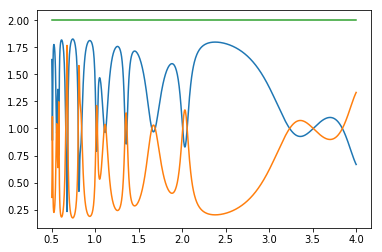

[[12.  0.  0.]
 [ 0. 17.  0.]
 [ 0.  0.  7.]]


In [10]:
ref = np.array(ref);
trans = np.array(trans)
plt.plot(wvlen_scan, ref);
plt.plot(wvlen_scan, trans);
plt.plot(wvlen_scan, ref+trans)
plt.show()

print(epsilon_tensor)